#  <center>Flu Shot Learning: Predicting H1N1 and Seasonal Flu Vaccines</center>
## <center>A [DrivenData](https://www.drivendata.org/) Challenge </center>

## <center>Introduction</center>

**<center> 
The objective of this challenge is to predict how likely individuals are to receive their H1N1 and seasonal flu vaccines. We are providing a probability prediction for each vaccine. The performance metric for our model will be the area under the receiver operating characteristic curve (ROC AUC). This is the metric that the competition will be using to evaluate our submission.**
</center>

## 0.0 Loading Our Necessary Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier




from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

## 1.0 Data Exploration 
### Let's take a look at our data before we begin working  with it

## 1.1 Loading the data

In [2]:
data_dir = 'datasets/' # Our datasets directory 

train_features = pd.read_csv(data_dir+'training_set_features.csv',index_col='respondent_id')
train_labels   = pd.read_csv(data_dir+'training_set_labels.csv',index_col='respondent_id')
test_features  = pd.read_csv(data_dir+'test_set_features.csv', index_col='respondent_id')

In [3]:
train_features.head(5) # Take a look at our training features 

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [4]:
train_labels.head(5) # Take a look at our training labels

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [5]:
# We see that our training features have  some null or NaN values
# Let's handle columns that may have an excess amount of these  values 
null_threshold = 0.15 # Drop columns where more than 15% of our data is missing values


null_rate = train_features.isnull().sum(axis=0) / len(train_features) # get the rate of NaN or Null appearances for each column.
null_bool = null_rate > null_threshold # Return a boolean pd.Series of whether or not each column had a null rate greater than our threshold
null_cols = list(null_bool[null_bool == True].index) # Create a list of the columns that had a null rate greater than our threshold. 

null_cols # Take a look at the columns with a null rate greater than our threshold defined above

['health_insurance',
 'income_poverty',
 'employment_industry',
 'employment_occupation']

In [6]:
# Let's create a helper function that drops the columns with a null rate
# greater than a given threshold 

def drop_null_threshold(df: pd.DataFrame, null_threshold = 0.15):

    null_rate = train_features.isnull().sum(axis=0) / len(train_features) # get the rate of NaN or Null appearances for each column.
    null_bool = null_rate > null_threshold # Return a boolean pd.Series of whether or not each column had a null rate greater than our threshold
    null_cols = list(null_bool[null_bool == True].index) 
    print('Columns dropped:\n', null_cols)
    
    # Drop columns with null rate greather than threshold
    df.drop(null_cols,
                    axis=1,
                    inplace=True)
    return None

In [7]:
# Remove columns with excess null values from our test and training feature dataframes
# drop_null_threshold(train_features)
# drop_null_threshold(test_features)

In [8]:
numeric_cols = train_features.select_dtypes(include=np.number)
test_numeric_cols = test_features.select_dtypes(include=np.number)
numeric_cols.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,2.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,0.0,0.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,1.0,0.0


In [9]:
non_numeric_cols =  train_features.select_dtypes(exclude=np.number)
test_non_numeric_cols =  test_features.select_dtypes(exclude=np.number)
numeric_cols.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,2.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,0.0,0.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,1.0,0.0


In [10]:
numeric_cols.isnull().values.any()

True

In [11]:
# Handle NaNs 
numeric_cols = numeric_cols.fillna(numeric_cols.fillna(9999))
test_numeric_cols = test_numeric_cols.fillna(numeric_cols.fillna(9999))
test_numeric_cols = test_numeric_cols.replace([np.inf, -np.inf], 9999)

In [12]:
numeric_cols.isnull().values.any()


False

In [13]:
test_numeric_cols.isnull().values.any()

True

In [14]:
list(numeric_cols.columns)

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children']

In [15]:
train = numeric_cols.merge(train_labels, on='respondent_id')



num_correlations = train.corr()
num_correlations.sort_values('h1n1_vaccine',ascending=False)['h1n1_vaccine']


h1n1_vaccine                   1.000000
seasonal_vaccine               0.377143
behavioral_antiviral_meds      0.024755
behavioral_face_mask           0.006808
opinion_h1n1_risk              0.003072
opinion_h1n1_sick_from_vacc   -0.002130
h1n1_knowledge                -0.003571
opinion_seas_vacc_effective   -0.004173
behavioral_wash_hands         -0.004371
opinion_seas_risk             -0.004542
opinion_h1n1_vacc_effective   -0.005165
h1n1_concern                  -0.005351
behavioral_large_gatherings   -0.007187
behavioral_outside_home       -0.008951
opinion_seas_sick_from_vacc   -0.010484
behavioral_avoidance          -0.011629
chronic_med_condition         -0.011858
behavioral_touch_face         -0.012138
household_adults              -0.013234
household_children            -0.013243
health_worker                 -0.014333
child_under_6_months          -0.014429
doctor_recc_h1n1              -0.091903
doctor_recc_seasonal          -0.091925
health_insurance              -0.224755


In [16]:
num_correlations.sort_values('seasonal_vaccine',ascending=False)['seasonal_vaccine']

seasonal_vaccine               1.000000
h1n1_vaccine                   0.377143
behavioral_antiviral_meds      0.021785
behavioral_face_mask           0.006110
behavioral_large_gatherings    0.003337
behavioral_avoidance           0.002731
behavioral_touch_face          0.002692
behavioral_outside_home        0.002515
h1n1_knowledge                 0.002383
h1n1_concern                  -0.000831
behavioral_wash_hands         -0.002839
opinion_seas_risk             -0.020552
opinion_h1n1_risk             -0.020885
opinion_h1n1_vacc_effective   -0.021113
opinion_seas_vacc_effective   -0.021645
opinion_h1n1_sick_from_vacc   -0.024169
opinion_seas_sick_from_vacc   -0.028952
child_under_6_months          -0.029064
health_worker                 -0.029124
chronic_med_condition         -0.029679
household_adults              -0.040616
household_children            -0.040675
doctor_recc_seasonal          -0.067315
doctor_recc_h1n1              -0.067346
health_insurance              -0.076641


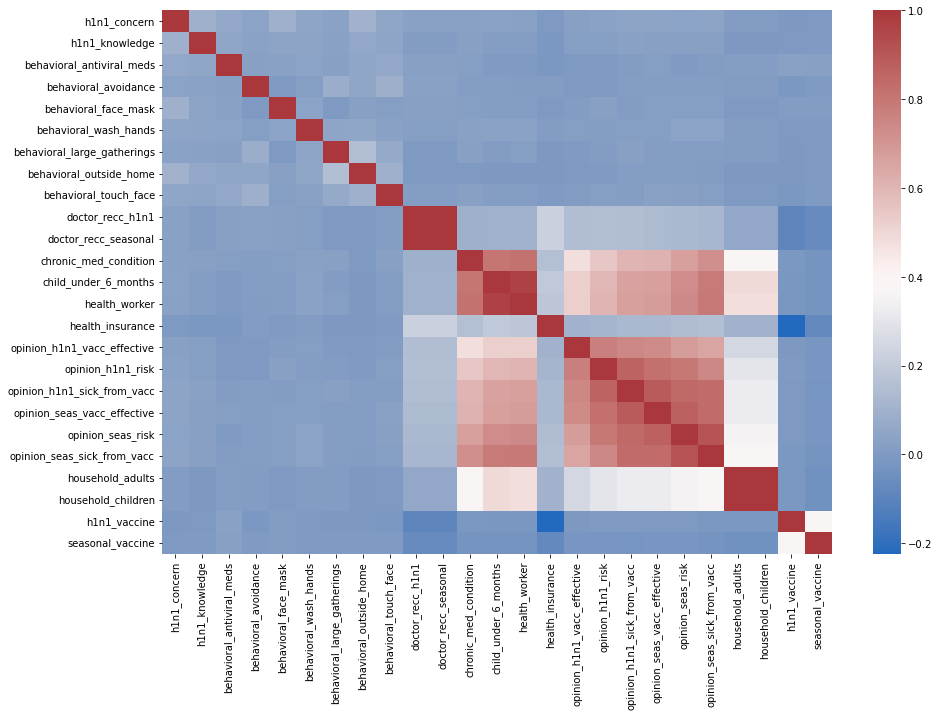

In [17]:
plt.figure(figsize=(15, 10))
colormap = sns.color_palette("vlag", as_cmap=True)
h1n1_heat = sns.heatmap(num_correlations, cmap=colormap)

In [18]:
non_numeric_cols

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",NaN,NaN
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...
26702,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,NaN,NaN
26703,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",fcxhlnwr,cmhcxjea
26704,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",NaN,NaN


In [19]:
non_numeric_cols = non_numeric_cols.apply(LabelEncoder().fit_transform)
test_non_numeric_cols = test_non_numeric_cols.apply(LabelEncoder().fit_transform)

In [20]:
non_num_corr = non_numeric_cols.corr()

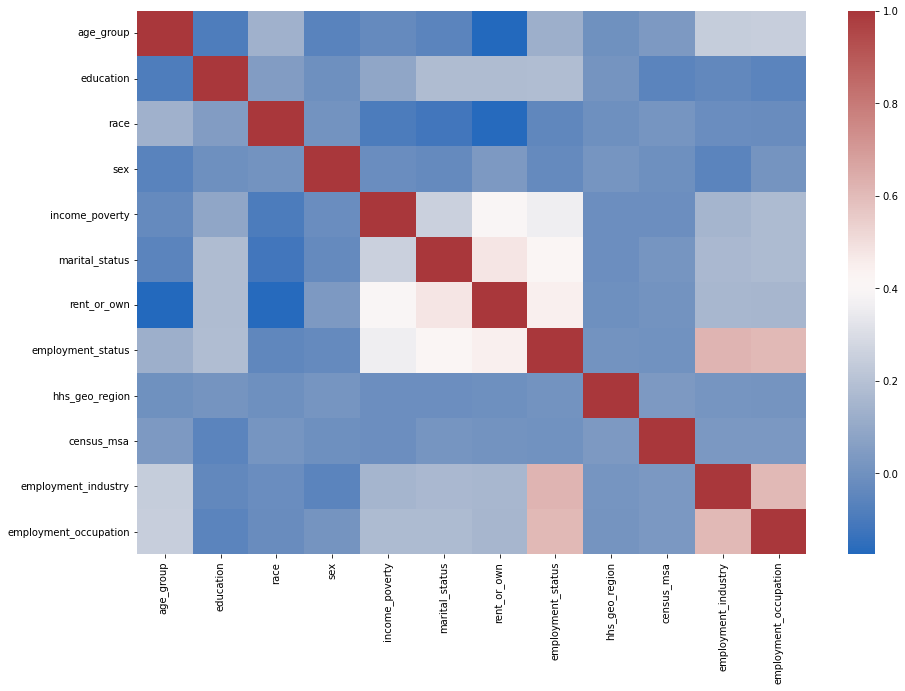

In [21]:
plt.figure(figsize=(15, 10))
h1n1_heat = sns.heatmap(non_num_corr,cmap=colormap)

In [22]:
train_features = numeric_cols.merge(non_numeric_cols,left_index=True,right_index=True)
test_features = test_numeric_cols.merge(test_non_numeric_cols,left_index=True,right_index=True)

In [23]:
train = train_features.merge(train_labels, on='respondent_id')

In [24]:
corr = train.corr()

In [25]:
test_features

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1,0,1,1,1,0,7,0,1,7
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,1,2,1,1,0,1,2,1,20
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,3,1,1,0,0,0,5,2,10,12
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3,0,0,0,0,1,5,0,21,23
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,1,0,0,6,2,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53410,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,3,0,3,2,2,3,2,1,21,23
53411,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,3,1,2,0,1,0,9,2,4,18
53412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,0,2,1,1,1,9,0,21,23


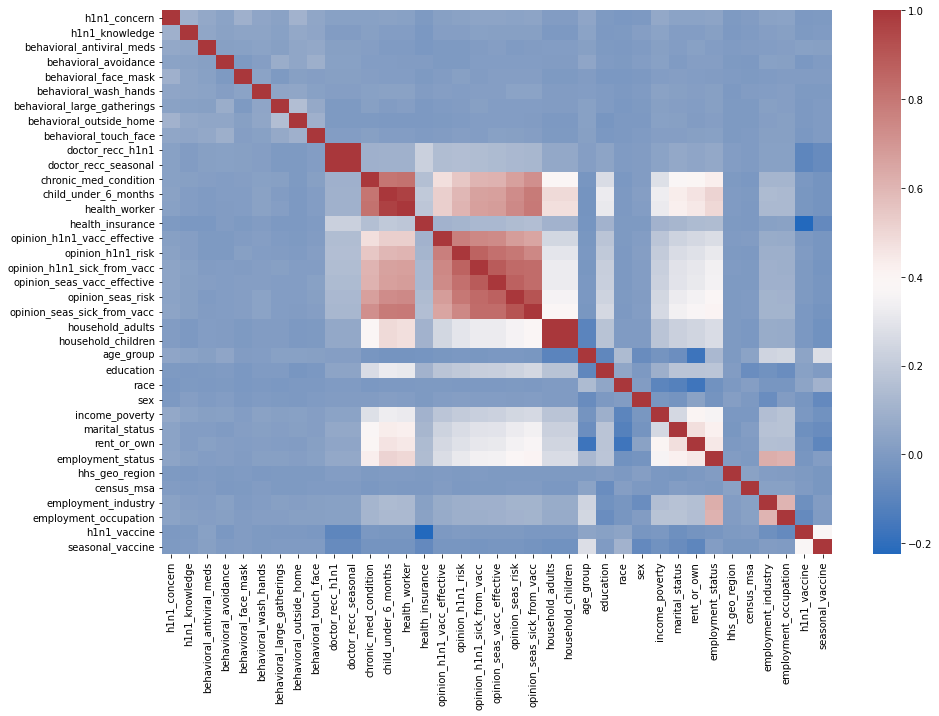

In [26]:
plt.figure(figsize=(15, 10))
corr_heat = sns.heatmap(corr,cmap=colormap)

In [27]:
corr.sort_values('h1n1_vaccine',ascending=False)['h1n1_vaccine']


h1n1_vaccine                   1.000000
seasonal_vaccine               0.377143
age_group                      0.041074
race                           0.041061
behavioral_antiviral_meds      0.024755
education                      0.024694
behavioral_face_mask           0.006808
opinion_h1n1_risk              0.003072
census_msa                     0.000420
opinion_h1n1_sick_from_vacc   -0.002130
hhs_geo_region                -0.003327
h1n1_knowledge                -0.003571
opinion_seas_vacc_effective   -0.004173
behavioral_wash_hands         -0.004371
opinion_seas_risk             -0.004542
opinion_h1n1_vacc_effective   -0.005165
h1n1_concern                  -0.005351
behavioral_large_gatherings   -0.007187
behavioral_outside_home       -0.008951
opinion_seas_sick_from_vacc   -0.010484
behavioral_avoidance          -0.011629
chronic_med_condition         -0.011858
behavioral_touch_face         -0.012138
income_poverty                -0.012236
household_adults              -0.013234


In [28]:
top_seasonal = (corr.sort_values('seasonal_vaccine',ascending=False)
            .drop(['h1n1_vaccine','seasonal_vaccine'],
                  axis=0)['seasonal_vaccine'])

In [29]:
top_h1n1 = (corr.sort_values('h1n1_vaccine',ascending=False)
            .drop(['h1n1_vaccine','seasonal_vaccine'],
                  axis=0)['h1n1_vaccine'])

In [30]:
np.abs(top_seasonal)

age_group                      0.277454
race                           0.101743
behavioral_antiviral_meds      0.021785
employment_status              0.011684
employment_industry            0.009639
behavioral_face_mask           0.006110
behavioral_large_gatherings    0.003337
behavioral_avoidance           0.002731
employment_occupation          0.002697
behavioral_touch_face          0.002692
behavioral_outside_home        0.002515
h1n1_knowledge                 0.002383
education                      0.002024
h1n1_concern                   0.000831
behavioral_wash_hands          0.002839
census_msa                     0.018275
hhs_geo_region                 0.018482
opinion_seas_risk              0.020552
opinion_h1n1_risk              0.020885
opinion_h1n1_vacc_effective    0.021113
opinion_seas_vacc_effective    0.021645
opinion_h1n1_sick_from_vacc    0.024169
opinion_seas_sick_from_vacc    0.028952
child_under_6_months           0.029064
health_worker                  0.029124


In [31]:
top_seasonal = list(top_seasonal.index)[:5]
top_seasonal

['age_group',
 'race',
 'behavioral_antiviral_meds',
 'employment_status',
 'employment_industry']

In [32]:
top_h1n1 = list(top_h1n1.index)[:5]

In [33]:
top_features = top_seasonal + top_h1n1

In [34]:
list( set(top_seasonal).union(set(top_h1n1)))

['race',
 'employment_status',
 'employment_industry',
 'education',
 'behavioral_face_mask',
 'behavioral_antiviral_meds',
 'age_group']

In [35]:
adaboost = AdaBoostClassifier(learning_rate = 0.85, n_estimators = 2000)
scores = {}
model = adaboost
for i in range(10):
    numeric_preprocessing_steps = Pipeline([ 
                                            ('standard_scaler', StandardScaler())
                                            ])


    estimators = MultiOutputClassifier(
        estimator=model
    )
    full_pipeline = Pipeline([
        ("numeric", numeric_preprocessing_steps),
        ("estimators", estimators)])
    X_train, X_eval, y_train, y_eval = train_test_split(
#         train[top_features],
        train_features,
        train_labels,
        test_size=0.2,
        shuffle=True,
        stratify=train_labels,
    )



    full_pipeline.fit(X_train, y_train)
    preds = full_pipeline.predict_proba(X_eval)



    y_preds = pd.DataFrame(
        {
            "h1n1_vaccine": preds[0][:,1],
            "seasonal_vaccine": preds[1][:,1],

        },
        index= y_eval.index
    )
    score = roc_auc_score(y_eval, y_preds)
    scores[str(model)] = score
    print(scores)
scores

{'AdaBoostClassifier(learning_rate=0.85, n_estimators=2000)': 0.8518806016970482}
{'AdaBoostClassifier(learning_rate=0.85, n_estimators=2000)': 0.8596283860391827}
{'AdaBoostClassifier(learning_rate=0.85, n_estimators=2000)': 0.8649895309758125}
{'AdaBoostClassifier(learning_rate=0.85, n_estimators=2000)': 0.8637632848657677}
{'AdaBoostClassifier(learning_rate=0.85, n_estimators=2000)': 0.8627917457762719}
{'AdaBoostClassifier(learning_rate=0.85, n_estimators=2000)': 0.8612777053169713}
{'AdaBoostClassifier(learning_rate=0.85, n_estimators=2000)': 0.858743671945382}
{'AdaBoostClassifier(learning_rate=0.85, n_estimators=2000)': 0.8649572563819492}
{'AdaBoostClassifier(learning_rate=0.85, n_estimators=2000)': 0.8571427705362695}
{'AdaBoostClassifier(learning_rate=0.85, n_estimators=2000)': 0.864124555529714}


{'AdaBoostClassifier(learning_rate=0.85, n_estimators=2000)': 0.864124555529714}

# Train entire set 

In [41]:
test_features  = pd.read_csv(data_dir+'test_set_features.csv', index_col='respondent_id')

numeric_test = test_features.select_dtypes(include=np.number)
non_numeric_test = test_features.select_dtypes(exclude=np.number)
non_numeric_test = non_numeric_test.apply(LabelEncoder().fit_transform)
test_features

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53410,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,dqpwygqj,"MSA, Principle City",1.0,1.0,NaN,NaN
53411,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,Below Poverty,Married,Rent,Employed,qufhixun,Non-MSA,1.0,3.0,fcxhlnwr,vlluhbov
53412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,qufhixun,"MSA, Not Principle City",1.0,0.0,NaN,NaN


In [42]:
test_features = numeric_test.merge(non_numeric_test,left_index=True,right_index=True)
test_features

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1,0,1,1,1,0,7,0,1,7
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,1,2,1,1,0,1,2,1,20
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,3,1,1,0,0,0,5,2,10,12
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3,0,0,0,0,1,5,0,21,23
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,1,0,0,6,2,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53410,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,3,0,3,2,2,3,2,1,21,23
53411,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,3,1,2,0,1,0,9,2,4,18
53412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,0,2,1,1,1,9,0,21,23


In [43]:
test_features.isnull().values.any()

True

In [44]:
test_features = test_features.fillna(9999)
test_features.isnull().values.any()

False

In [45]:
for column in test_features:
    print(column, ': ', np.max(test_features[column]))

h1n1_concern :  9999.0
h1n1_knowledge :  9999.0
behavioral_antiviral_meds :  9999.0
behavioral_avoidance :  9999.0
behavioral_face_mask :  9999.0
behavioral_wash_hands :  9999.0
behavioral_large_gatherings :  9999.0
behavioral_outside_home :  9999.0
behavioral_touch_face :  9999.0
doctor_recc_h1n1 :  9999.0
doctor_recc_seasonal :  9999.0
chronic_med_condition :  9999.0
child_under_6_months :  9999.0
health_worker :  9999.0
health_insurance :  9999.0
opinion_h1n1_vacc_effective :  9999.0
opinion_h1n1_risk :  9999.0
opinion_h1n1_sick_from_vacc :  9999.0
opinion_seas_vacc_effective :  9999.0
opinion_seas_risk :  9999.0
opinion_seas_sick_from_vacc :  9999.0
household_adults :  9999.0
household_children :  9999.0
age_group :  4
education :  4
race :  3
sex :  1
income_poverty :  3
marital_status :  2
rent_or_own :  2
employment_status :  3
hhs_geo_region :  9
census_msa :  2
employment_industry :  21
employment_occupation :  23


In [46]:
AdaBoostClassifier(learning_rate = 0.85, n_estimators = 2000)
numeric_preprocessing_steps = Pipeline([ 
                                        ('standard_scaler', StandardScaler())
                                        ])


estimators = MultiOutputClassifier(
    estimator=model
)
full_pipeline = Pipeline([
    ("numeric", numeric_preprocessing_steps),
    ("estimators", estimators)])
# Retrain Model on Full Dataset

full_pipeline.fit(train_features, train_labels)

None  # So we don't print out the whole pipeline representation





test_probas = full_pipeline.predict_proba(test_features)




submission_df = pd.read_csv(data_dir + "submission_format.csv",
                            index_col = "respondent_id")





# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features.index.values,
                              submission_df.index.values)


# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = test_probas[0][:,1]
submission_df["seasonal_vaccine"] = test_probas[1][:,1]
submission_df.to_csv('/home/ray/Documents/DrivenData/Flu Shot Learning: Predicting H1N1 and Seasonal Flu Vaccines/my_submission.csv',
                     index=True)


ValueError: The base estimator should implement a fit method